In [4]:
%cd Code/Python/

d:\Users\Subhy\Documents\GitHub\Complex_Synapse\Code\Python


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy_linalg as la

In [2]:
import sl_py_tools.matplotlib_tricks as mplt
import sl_py_tools.numpy_tricks.markov as ma
import sl_py_tools.numpy_tricks.markov_param as mp

In [5]:
import complex_synapse as cs

In [13]:
from sl_py_tools.import_tricks import reload

In [34]:
np.set_printoptions(precision=3, suppress=False)

In [0]:
%pdoc plt.box

In [37]:
reload(cs)
reload(mp)

Reloading complex_synapse.synapse_memory_model
Reloading sl_py_tools.numpy_tricks
Reloading complex_synapse.synapse_base
Reloading complex_synapse.builders
Reloading complex_synapse.synapse_opt
Reloading complex_synapse.optimise
Reloading sl_py_tools.iter_tricks
Reloading sl_py_tools.arg_tricks
Reloading sl_py_tools.display_tricks
Reloading sl_py_tools.containers
Reloading sl_py_tools.range_tricks
Reloading sl_py_tools.abc_tricks
Reloading sl_py_tools.slice_tricks
Reloading sl_py_tools.numpy_tricks.markov
Reloading sl_py_tools.numpy_tricks
Reloading sl_py_tools.numpy_tricks.logic


In [0]:
serial = cs.SynapseMemoryModel.build(cs.builders.build_serial, 12, jmp=0.7)
cascade = cs.SynapseMemoryModel.build(cs.builders.build_cascade, 12, jmp=0.7)

In [0]:
t = la.geomspace(0.1, 1e4, 50)
serial_snr = serial.snr_exp_ave(t)
cascade_snr = cascade.snr_exp_ave(t)

In [0]:
plt.loglog(t, serial_snr, label='serial')
plt.loglog(t, cascade_snr, label='cascade')
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

In [6]:
nst = 10
options = {'repeats': 10, 'method': 'trust-constr'}

In [7]:
s = la.geomspace(1e-4, 10, 50)
envelope_srl, models_srl = cs.optimise.optim_laplace_range(s, nst, serial=True, **options)
envelope_gen, models_gen = cs.optimise.optim_laplace_range(s, nst, serial=False, **options)

_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next

C:\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next

C:\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next

C:\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next

C:\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:153: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_

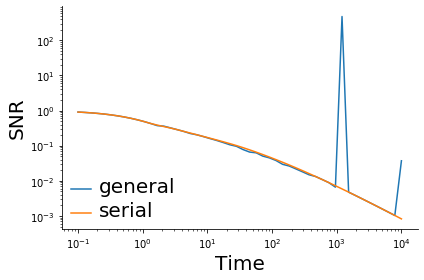

In [8]:
plt.loglog(1/s, envelope_gen * s, label='general')
plt.loglog(1/s, envelope_srl * s, label='serial')
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

In [11]:
np.savez_compressed("optim", s=s, envelope_gen=envelope_gen, envelope_srl=envelope_srl, models_gen=models_gen, models_srl=models_srl, options=options)

In [35]:
rconds = cs.optimise.check_rcond_range(s, models_gen, serial=False)
rconds

{'serial': False, 'ring': False, 'uniform': False, 'drn': (0, 0)}


lnarray([1.001e-05, 1.785e-04, 2.021e-04, 2.290e-04, 2.596e-04, 2.947e-04,
         3.349e-04, 3.810e-04, 4.340e-04, 1.000e-05, 6.467e-04, 6.479e-04,
         7.432e-04, 8.544e-04, 1.111e-03, 1.279e-03, 1.451e-03, 1.706e-03,
         2.278e-03, 2.299e-03, 2.678e-03, 3.543e-03, 3.643e-03, 5.419e-03,
         6.261e-03, 6.411e-03, 8.284e-03, 8.977e-03, 1.013e-02, 1.322e-02,
         1.343e-02, 1.503e-02, 2.662e-02, 1.778e-02, 1.699e-02, 3.715e-02,
         3.086e-02, 4.325e-02, 3.815e-02, 4.161e-02, 4.402e-02, 4.819e-02,
         5.729e-02, 4.795e-02, 9.292e-02, 5.814e-02, 4.497e-02, 8.813e-02,
         9.802e-02, 7.227e-02])

In [39]:
s * envelope_gen

lnarray([3.730e-02, 1.034e-03, 1.293e-03, 1.614e-03, 2.012e-03, 2.505e-03,
         3.112e-03, 3.858e-03, 4.774e-03, 4.773e+02, 6.613e-03, 8.901e-03,
         1.089e-02, 1.328e-02, 1.490e-02, 1.811e-02, 2.192e-02, 2.642e-02,
         2.956e-02, 3.790e-02, 4.507e-02, 5.058e-02, 6.276e-02, 6.597e-02,
         7.784e-02, 9.631e-02, 1.065e-01, 1.233e-01, 1.415e-01, 1.599e-01,
         1.819e-01, 2.049e-01, 2.229e-01, 2.559e-01, 2.879e-01, 3.226e-01,
         3.610e-01, 3.736e-01, 4.300e-01, 4.883e-01, 5.469e-01, 6.042e-01,
         6.588e-01, 7.095e-01, 7.554e-01, 7.962e-01, 8.317e-01, 8.621e-01,
         8.877e-01, 9.091e-01])

In [40]:
cs.optimise.reoptim_laplace_range([0, 9], s, models_gen, envelope_gen, serial=False, **options)

TypeError: reoptim_laplace_range() missing 2 required positional arguments: 'models' and 'snr'